Here are all of the required libraries and dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Now loading all of the data from my directories, with each one having 7 sub-folders with their titles as the labels of the images.

In [2]:
batch_size = 64
input_shape = (224, 224, 3)

train_dir = '/home/mint/repos/Teeth_Dataset/Training'
validation_dir = '/home/mint/repos/Teeth_Dataset/Testing'
test_dir = '/home/mint/repos/Teeth_Dataset/Validation'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size)

val_gen = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


Examining data further

In [3]:
classes = len(train_gen.class_indices)
class_names = list(train_gen.class_indices.keys())

print(f'training batch: {len(next(train_gen))}')
print(f'validation: {len(val_gen)}')
print(f'testing: {len(test_gen)} and there are {classes} classes with names: {class_names}')

training batch: 2
validation: 17
testing: 17 and there are 7 classes with names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


Checking that all images are of the same size and outputing a few augmented images

All images have the same shape: (224, 224, 3), first one's label: Gum


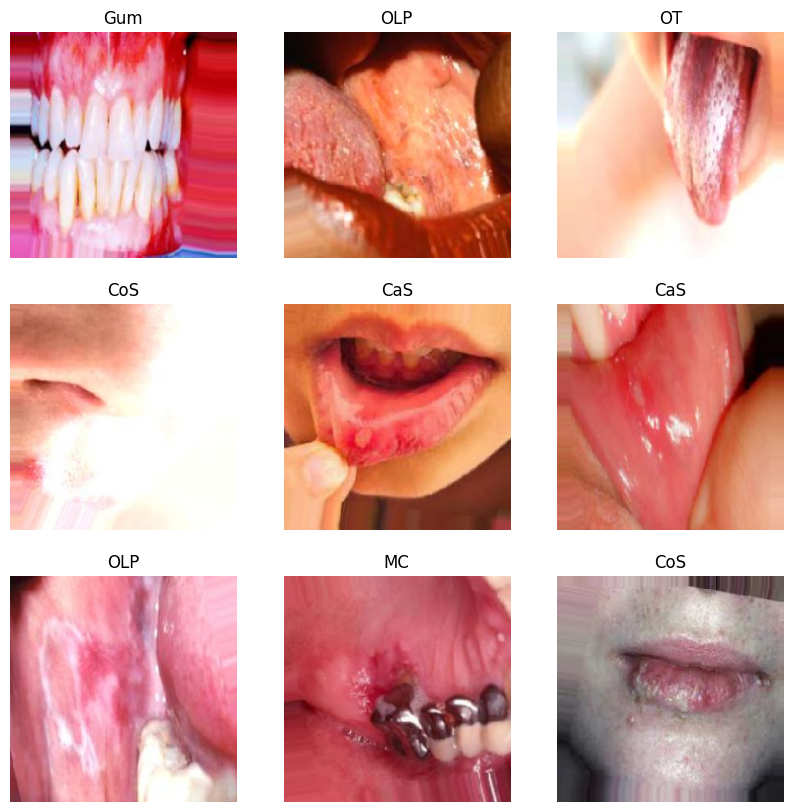

In [4]:
first_image_shape = None
consistent_shape = True

images, labels = next(train_gen)

for i in range(len(labels)):
    if first_image_shape is None:
        first_image_shape = images[i].shape
        first_image_label = class_names[np.argmax(labels[i])]
    else:
        if images[i].shape != first_image_shape:
            print(f"Mismatch found: {images[i].shape} != {first_image_shape}")
            consistent_shape = False
            break

if consistent_shape:
    print(f"All images have the same shape: {first_image_shape}, first one's label: {first_image_label}")
else:
    print("Not all images have the same shape.")


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

Now loading the pre-trained model of choice, here I used ResNet50V2 as it seemed to converge most rapidly

In [5]:
#base_model = tf.keras.applications.VGG16(weights='imagenet', input_shape= input_shape, classes=classes, include_top=False)
base_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', input_shape = input_shape, classes = classes, include_top = False)
#base_model = tf.keras.applications.MobileNetV3Large(weights = 'imagenet', input_shape = input_shape, classes = classes, include_top = False)
base_model.trainable = False

inputs = tf.keras.Input(input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)    #uncomment this to get a png file for the model

I0000 00:00:1724923888.524375   54195 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724923888.764836   54195 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724923888.764875   54195 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724923888.767209   54195 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724923888.767239   54195 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Here I examined the initial accuracy of the model, defined a custom callback, and the most exciting bit, started the training process!

In [9]:
lr = 2e-3
epochs = 15
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

loss0, acc0 = model.evaluate(val_gen)
print(f'loss0: {loss0}, acc0: {acc0}')

train_size = len(train_gen)
val_size = len(val_gen)
train_steps = int(train_size / batch_size)
val_steps = int(val_size / batch_size)

class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% validation accuracy, stopping training!")
            self.model.stop_training = True

stop_callback = StopTrainingAtAccuracy(target_accuracy=0.93)

model_history_1 = model.fit(
    train_gen, validation_data = val_gen,
    epochs = epochs, 
    steps_per_epoch = train_steps, validation_steps = val_steps, callbacks = [stop_callback])
history1_df = pd.DataFrame(model_history_1.history)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9882 - loss: 0.0320
loss0: 0.025450097396969795, acc0: 0.9912451505661011
Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 326ms/step - accuracy: 0.5743 - loss: 2.2179 - val_accuracy: 0.1556 - val_loss: 13.6094
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.2589 - loss: 2.2921 - val_accuracy: 0.1274 - val_loss: nan
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.3312 - loss: 2.0655 - val_accuracy: 0.1274 - val_loss: nan
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.3805 - loss: 1.8197 - val_accuracy: 0.1547 - val_loss: 13.5068
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.4659 - loss: 1.4815 - val_accuracy: 0.2510 - val_loss: 7.1810
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.6118 - loss: 1.1365 - val_accuracy: 0.3619 - val_loss: 5.9865
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.7881 - loss: 0.6332 - val_accuracy:

Then, an even more exciting part, I will finetune some of the base layers of ResNet50 to extract even more performance!

In [10]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers[:130]:
  layer.trainable = False

base_lr = 2e-5
base_epochs = 10
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate=base_lr),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

model_history_2 = model.fit(
    train_gen, validation_data = val_gen,
    epochs = base_epochs, 
    steps_per_epoch = train_steps, validation_steps = val_steps)
history2_df = pd.DataFrame(model_history_2.history)

Number of layers in the base model:  190
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 394ms/step - accuracy: 0.9802 - loss: 0.0625 - val_accuracy: 0.9747 - val_loss: 0.0810
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.9841 - loss: 0.0554 - val_accuracy: 0.9776 - val_loss: 0.0612
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9860 - loss: 0.0457 - val_accuracy: 0.9805 - val_loss: 0.0559
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.9926 - loss: 0.0344 - val_accuracy: 0.9796 - val_loss: 0.0531
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.9890 - loss: 0.0450 - val_accuracy: 0.9796 - val_loss: 0.0521
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.9844 - loss: 0.0575 - val_accuracy: 0.9805 - val_loss: 0.0511
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.9869 - loss: 0.0385 - val_accuracy: 0.9815 - val_loss: 0.0503
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - a

And ultimately, the most awated part, results!

 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9983 - loss: 0.0328

/home/mint/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9888 - loss: 0.0444
loss: 0.05358315259218216, acc: 0.9824903011322021
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2

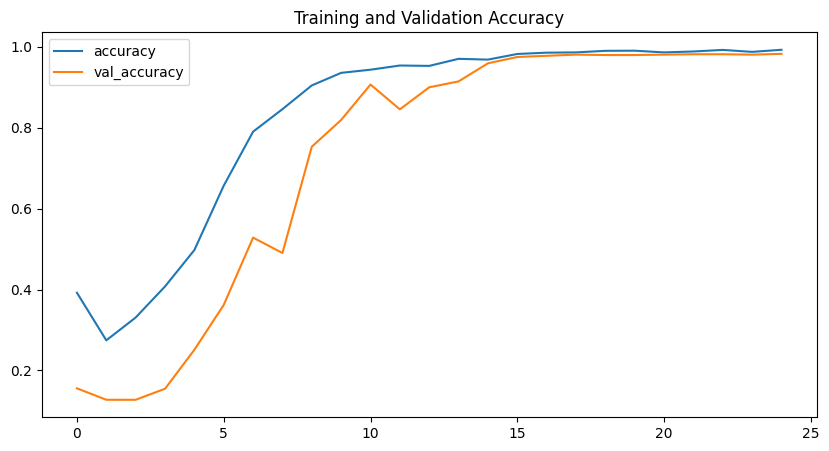

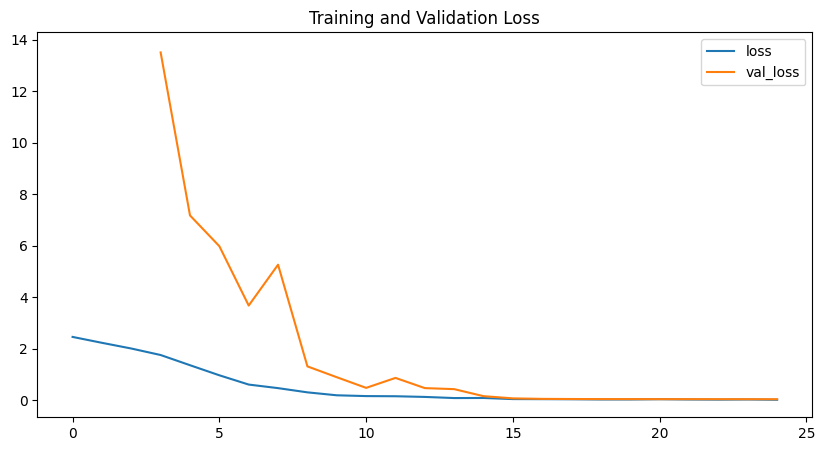

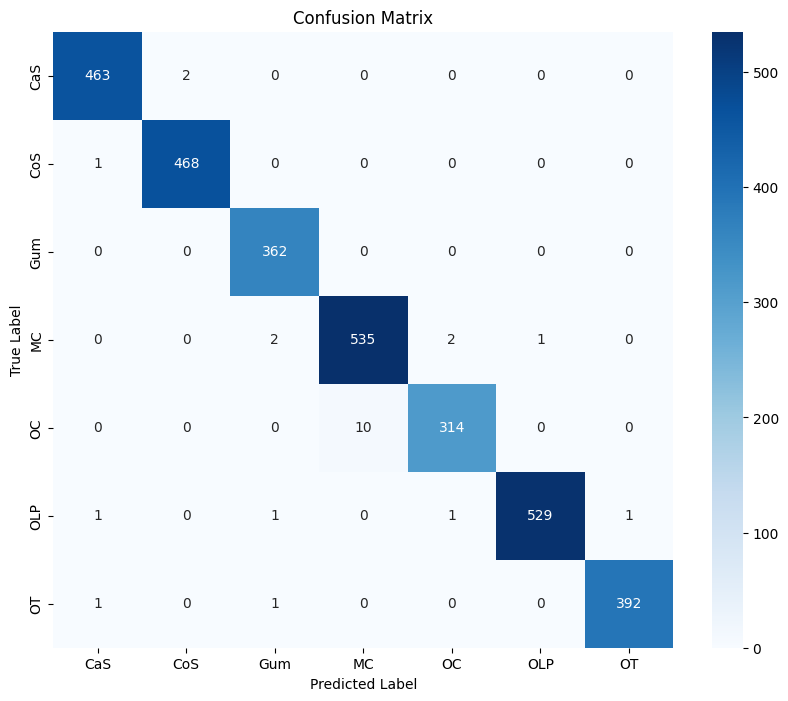

In [11]:
history2_df.index = history2_df.index + len(history1_df)
combined_history_df = pd.concat([history1_df, history2_df])
combined_history_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 5), title='Training and Validation Accuracy')
combined_history_df[['loss', 'val_loss']].plot(figsize=(10, 5), title='Training and Validation Loss')

loss, acc = model.evaluate(test_gen)
print(f'loss: {loss}, acc: {acc}')

true_labels = []
pred_labels = []

for i in range(len(train_gen)):
    images, labels = next(train_gen) 
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

from sklearn.metrics import confusion_matrix

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

conf_matrix = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

import seaborn as sns

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels = class_names,
            yticklabels = class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

model.save('resnet50v2_pretuned_final.keras')